In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import time
import scipy.optimize

In [2]:
initializer = tf.keras.initializers.GlorotUniform #모델의 초기의 가중치 값 설정(균등분포)
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((None,2)),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 20, activation = 'tanh', kernel_initializer=initializer),
    tf.keras.layers.Dense(units = 1, activation='linear')
])

NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 20)          60        
                                                                 
 dense_1 (Dense)             (None, None, 20)          420       
                                                                 
 dense_2 (Dense)             (None, None, 20)          420       
                                                                 
 dense_3 (Dense)             (None, None, 20)          420       
                                                                 
 dense_4 (Dense)             (None, None, 20)          420       
                                                                 
 dense_5 (Dense)             (None, None, 20)          420       
                                                                 
 dense_6 (Dense)             (None, None, 20)          4

In [3]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)
iter_num=0
instant_loss=0
train_loss_history=[]

In [4]:
def save_weights(net):
    net.save_weights('burgers.h5')

def load_weights(net):
    net.load_weights('burgers.h5')

In [5]:
#Burgers Equation
def physics_net(net, xt):
    x = xt[:, 0:1]
    t = xt[:, 1:2]
    with tf.GradientTape(persistent=True) as tape_2:
        tape_2.watch(t)
        tape_2.watch(x)
        with tf.GradientTape(persistent=True) as tape_1:
            tape_1.watch(t)
            tape_1.watch(x)
            xt_t = tf.concat([x,t], axis=1)
            u = net(xt_t)
        u_x = tape_1.gradient(u, x)
        u_t = tape_1.gradient(u, t)
    u_xx = tape_2.gradient(u_x, x)

    return u_t + u*u_x - (0.01/np.pi)*u_xx
#print(physics_net(NN,tf.convert_to_tensor(xt_col_data, dtype=tf.float32)))

In [6]:
#MSE = MSE_u + MSE_f
def compute_loss(f, u_bnd_hat, u_bnd_sol):

    loss_col = tf.reduce_mean(tf.square(f))
    loss_bnd = tf.reduce_mean(tf.square(u_bnd_hat - u_bnd_sol))

    loss = loss_col + loss_bnd

    return loss

In [7]:
def compute_grad(net, xt_col, xt_bnd, u_bnd_sol):
    with tf.GradientTape() as tape:
        f = physics_net(net,xt_col)
        u_bnd_hat = net(xt_bnd)

        loss = compute_loss(f, u_bnd_hat, u_bnd_sol)

    grads = tape.gradient(loss, net.trainable_variables) #gradients 계산

    return loss, grads

In [8]:
#어떤 이벤트가 발생했거나 특정 시점에 도달했을 때 시스템에서 호출하는 함수
def callback(arg=None):
    global iter_num
    global instant_loss
    if iter_num % 10 == 0:
        print('iter=', iter_num, ', loss=', instant_loss)
        train_loss_history.append([iter_num, instant_loss])

    iter_num=iter_num+1

In [9]:
#Adam optimizer를 사용하여 gradients를 통해 backpropagation(weight 갱신)을 진행
def train_with_adam(net, xt_col, xt_bnd, u_bnd_sol, adam_num):

    def learn():
        loss, grads = compute_grad(net, xt_col, xt_bnd, u_bnd_sol)

        optm.apply_gradients(zip(grads, net.trainable_variables))

        return loss
    
    #지정한 횟수만큼 반복한다.
    for iter in range(int(adam_num)):

        loss = learn()
        
        global instant_loss
        instant_loss = loss.numpy()
        callback()

In [10]:
#L-BFGS기법을 사용하여 gradients를 통해 backpropagation(weight 갱신)을 진행
def train_with_lbfgs(net, xt_col, xt_bnd, u_bnd_sol, lbfgs_num):

    def vec_weight():
        # vectorize weights
        weight_vec = []

        # Loop over all weights(위에서 만든 신경망 NN의 layers의학습 가능한 가중치_weight,biasis)
        for v in net.trainable_variables:
            weight_vec.extend(v.numpy().flatten())

        weight_vec = tf.convert_to_tensor(weight_vec)
        return weight_vec
    w0 = vec_weight().numpy()

    def restore_weight(weight_vec):
        # restore weight vector to model weights
        idx = 0
        for v in net.trainable_variables:
            vs = v.shape

            # weight matrices
            if len(vs) == 2:
                sw = vs[0] * vs[1]
                updated_val = tf.reshape(weight_vec[idx:idx + sw], (vs[0], vs[1]))
                idx += sw

            # bias vectors
            elif len(vs) == 1:
                updated_val = weight_vec[idx:idx + vs[0]]
                idx += vs[0]

            # assign variables (Casting necessary since scipy requires float64 type)
            v.assign(tf.cast(updated_val, dtype=tf.float32))


    def loss_grad(w):
        # update weights in model
        restore_weight(w)
        loss, grads = compute_grad(net, xt_col, xt_bnd, u_bnd_sol)
        # vectorize gradients
        grad_vec = []
        for g in grads:
            grad_vec.extend(g.numpy().flatten())

        # gradient list to array
        # scipy-routines requires 64-bit floats
        loss = loss.numpy().astype(np.float64)
        global instant_loss
        instant_loss = loss
        grad_vec = np.array(grad_vec, dtype=np.float64)

        return loss, grad_vec
    
    return scipy.optimize.minimize(fun=loss_grad, #The objective function to be minimized
                                    x0=w0, #Array of real elements of size (n,) as Initial guess
                                    jac=True, 
                                    method='L-BFGS-B',
                                    callback=callback,
                                    options={'maxiter': lbfgs_num, #Maximum number of iterations
                                             'maxfun': 50000, #Maximum number of function evaluations
                                             'maxcor': 50, #The maximum number of variable metric corrections used to define the limited memory matrix
                                             'maxls': 50, #Maximum number of line search steps (per iteration). Default is 20
                                             'ftol': 1.0 * np.finfo(float).eps})

In [11]:
def burgers_data():

    # set number of data points
    N_b = 500    # boundary
    N_t = 500    # initial time
    N_c = 20000  # collocation point

    # set boundary
    xmin = -1.0
    xmax = 1.0
    tmin = 0.0
    tmax = 1.0

    # initial condition
    initial_xt = np.linspace([xmin, tmin], [xmax, tmin], N_t)
    initial_u = -np.sin(np.pi * initial_xt[:,0]).reshape(-1,1)

    # boundary condition
    boundary_up = np.linspace([xmax, tmin], [xmax, tmax], N_b)
    boundary_up_sol = np.zeros((N_b, 1))
    boundary_down = np.linspace([xmin, tmin], [xmin, tmax], N_b)
    boundary_down_sol = np.zeros((N_b, 1))

    # collection of initial and boundary condition
    xt_bnd = np.concatenate([initial_xt, boundary_up, boundary_down], axis=0)
    u_bnd_sol = np.concatenate([initial_u, boundary_up_sol, boundary_down_sol], axis=0)


    # collocation point
    t_col_data = np.random.uniform(tmin, tmax, [N_c, 1])
    x_col_data = np.random.uniform(xmin, xmax, [N_c, 1])
    xt_col_data = np.concatenate([x_col_data, t_col_data], axis=1)
    xt_col = np.concatenate((xt_col_data, xt_bnd), axis=0)

    # convert all to tensors
    xt_col = tf.convert_to_tensor(xt_col, dtype=tf.float32)
    xt_bnd = tf.convert_to_tensor(xt_bnd, dtype=tf.float32)
    u_bnd_sol = tf.convert_to_tensor(u_bnd_sol, dtype=tf.float32)

    return xt_col, xt_bnd, u_bnd_sol

In [12]:
def train(net, adam_num, lbfgs_num):

    xt_col, xt_bnd, u_bnd_sol = burgers_data()

    # Start timer
    t0 = time.time()
    train_with_adam(net, xt_col, xt_bnd, u_bnd_sol, adam_num)
    # Print computation time
    print('\nComputation time of adam: {} seconds'.format(time.time() - t0))
    t1 = time.time()
    train_with_lbfgs(net, xt_col, xt_bnd, u_bnd_sol, lbfgs_num)
    # Print computation time
    print('\nComputation time of L-BFGS-B: {} seconds'.format(time.time() - t1))

    save_weights(net)
    
    global train_loss_history
    np.savetxt('loss.txt', train_loss_history)
    train_loss_history = np.array(train_loss_history)

    plt.plot(train_loss_history[:, 0], train_loss_history[:, 1])
    plt.yscale("log")
    plt.show()


Computation time of adam: 0.0 seconds
iter= 0 , loss= 0.2827630639076233
iter= 10 , loss= 0.13529279828071594
iter= 20 , loss= 0.09801027178764343
iter= 30 , loss= 0.08262801915407181
iter= 40 , loss= 0.07385227084159851
iter= 50 , loss= 0.07202278077602386
iter= 60 , loss= 0.06944485008716583
iter= 70 , loss= 0.0676758661866188
iter= 80 , loss= 0.06175821274518967
iter= 90 , loss= 0.057824213057756424
iter= 100 , loss= 0.05094491317868233
iter= 110 , loss= 0.048601485788822174
iter= 120 , loss= 0.04615176469087601
iter= 130 , loss= 0.04491104558110237
iter= 140 , loss= 0.04293534532189369
iter= 150 , loss= 0.040689464658498764
iter= 160 , loss= 0.038890134543180466
iter= 170 , loss= 0.03734947741031647
iter= 180 , loss= 0.03599351644515991
iter= 190 , loss= 0.03340107575058937
iter= 200 , loss= 0.02994929440319538
iter= 210 , loss= 0.025032611563801765
iter= 220 , loss= 0.020145930349826813
iter= 230 , loss= 0.01721278950572014
iter= 240 , loss= 0.016156086698174477
iter= 250 , loss=

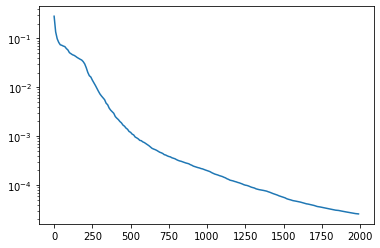

In [13]:
adam_num = 0
lbfgs_num = 2000
train(NN, adam_num, lbfgs_num)

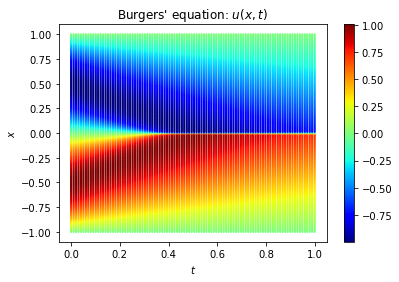

In [15]:
x_input = np.linspace(-1.0, 1.0, 256)
t_input = np.linspace(0.0, 1.0, 100)

x_data = x_input.reshape(-1,1)

uxt_res = []

for t in t_input:
    t_data = t * np.ones(x_data.shape)
    xt_data = np.concatenate([x_data, t_data], axis=1)
    u_pred = NN.predict(tf.convert_to_tensor(xt_data, dtype=tf.float32))
    uxt = np.concatenate([xt_data, u_pred], axis=1)
    uxt_res.append(uxt)

uxt_res = np.array(uxt_res)
uxt_res = uxt_res.reshape(-1,3)

# plotting
plt.figure(1)
plt.scatter(uxt_res[:, 1], uxt_res[:, 0], c=uxt_res[:,2], s=1, cmap="jet")
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title("Burgers' equation: $u(x,t)$")
plt.show()

In [18]:
import scipy.io
data = scipy.io.loadmat('burgers_shock.mat')
t = data["t"].flatten()
x = data["x"].flatten()

pre_xt = []

for i in range(256):
    for s in range(100):
        pre_xt.append([x[i], t[s]])

pre_xt = np.array(pre_xt)
pre_u = NN.predict(pre_xt)

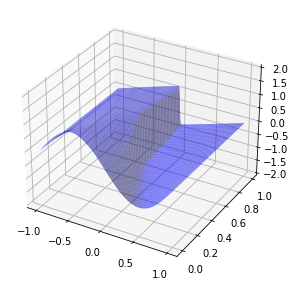

In [20]:
import scipy.io
data = scipy.io.loadmat('burgers_shock.mat')

t = data["t"].flatten()
x = data["x"].flatten()
pre = pre_u.reshape(256, 100).T

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X = np.array([t for i in range(256)]).T
Y = np.array([x for i in range(100)])
Z = pre



ax.plot_surface(Y, X, Z, alpha=0.5, color="blue")
ax.set_zlim(-2, 2)

plt.tight_layout()
plt.show()

In [21]:
exact = np.real(data["usol"]).T
error_1 = np.linalg.norm(exact-pre, 2)/np.linalg.norm(exact, 2)

In [22]:
(np.linalg.norm(exact-pre, 2))/(np.linalg.norm(exact, 2)) #L2-norm-error

0.0021168587814000806

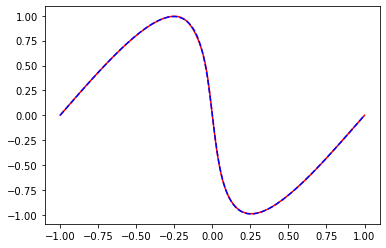

In [24]:
plt.plot(x, pre[25], color="red")
plt.plot(x, exact[25], "b--")

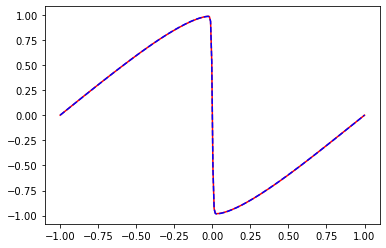

In [25]:
plt.plot(x, pre[50], color="red")
plt.plot(x, exact[50], "b--")

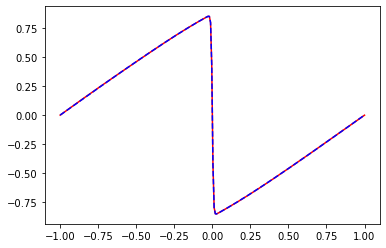

In [26]:
plt.plot(x, pre[75], color="red")
plt.plot(x, exact[75], "b--")